# Requirements

In [98]:
# Add as many imports as you need.
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Laboratory Exercise - Run Mode (8 points)

## Introduction
In this laboratory assignment, the primary objective is to use Long Short-Term Memory (LSTM) networks for time series forecasting in order to predict the current **mean temperature** in the city of Delhi. To accomplish this use data from the past three days, which includes information such as the **mean temperature**, **humidity**, **wind speed**, and **mean pressure**. The goal is to employ LSTM, a type of recurrent neural network, to effectively forecast the future mean temperature based on the provided historical data.

**Note: You are required to perform this laboratory assignment on your local machine.**

## The Climate Dataset

## Downloading the Climate Dataset

## Exploring the Climate Dataset
This dataset consists of daily weather records for the city of Delhi spanning a period of 4 years (from 2013 to 2017). The dataset includes the following attributes:

- date - date in the format YYYY-MM-DD,
- meantemp - mean temperature averaged from multiple 3-hour intervals in a day,
- humidity - humidity value for the day (measured in grams of water vapor per cubic meter volume of air),
- wind_speed - wind speed measured in kilometers per hour, and
- meanpressure - pressure reading of the weather (measured in atm).

*Note: The dataset is complete, with no missing values in any of its entries.*

Load the dataset into a `pandas` data frame.

In [100]:
# Write your code here. Add as many boxes as you need.
df = pd.read_csv('datasets/climate-data.csv')

In [10]:
df

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...,...
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000


In [102]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

In [104]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762


Explore the dataset using visualizations of your choice.

<Axes: >

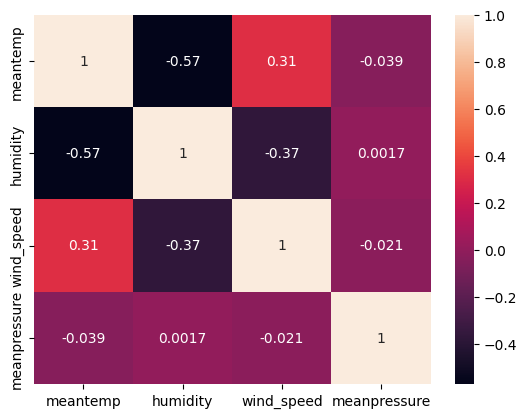

In [14]:
# Write your code here. Add as many boxes as you need.
sns.heatmap(df.corr(), annot=True)

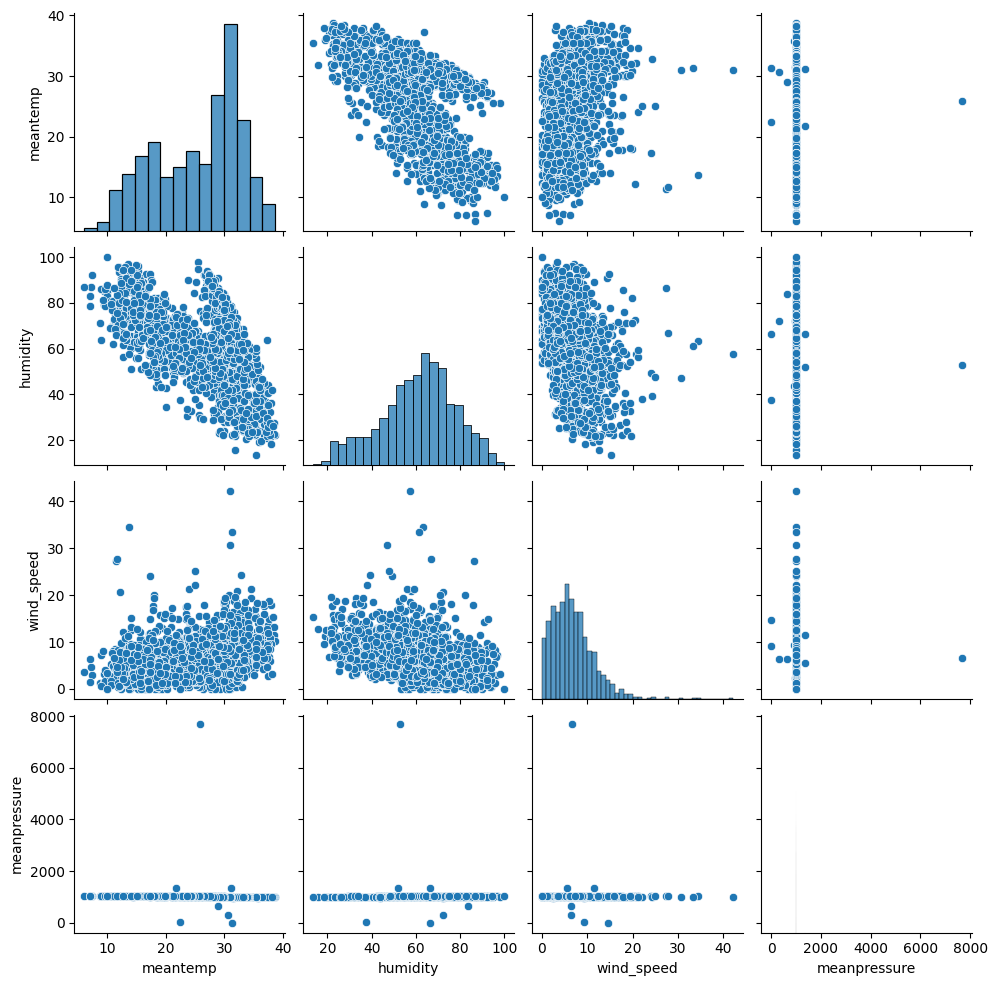

In [15]:
sns.pairplot(df)

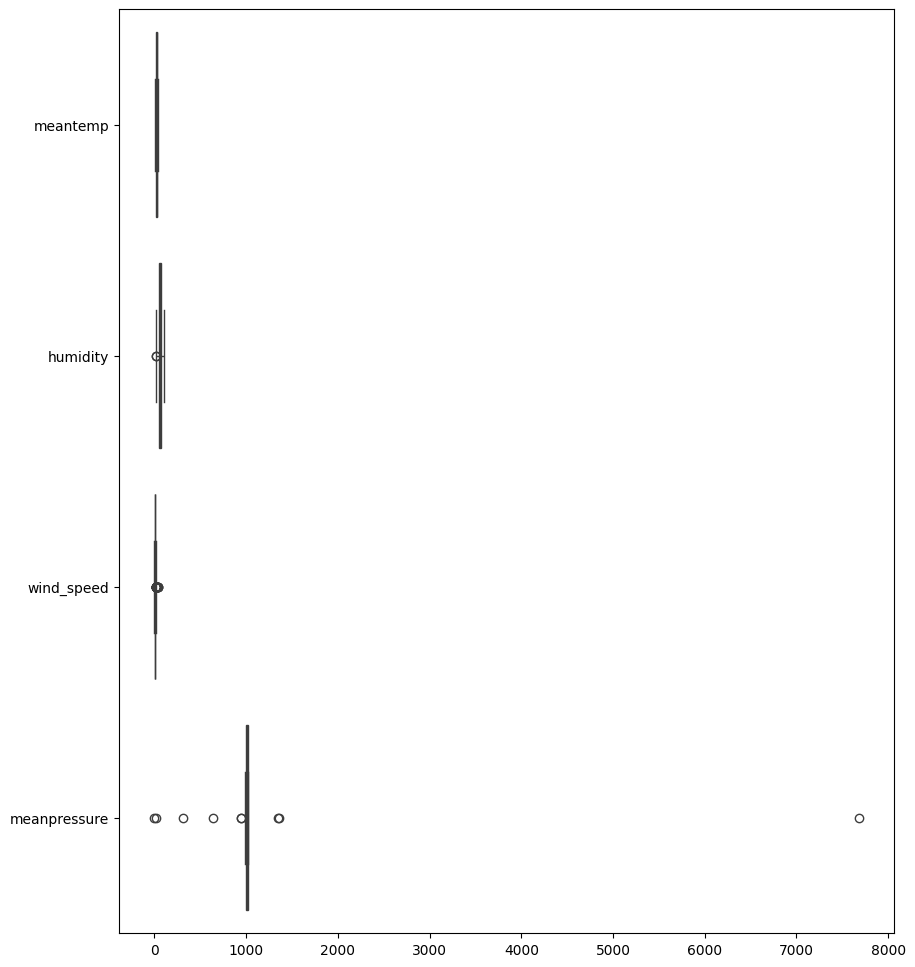

In [16]:
plt.figure(figsize=(10,12))
sns.boxplot(df, orient='h')
plt.show()

## Feauture Extraction
Apply a lag of one, two, and three days to each feature, creating a set of features representing the meteorological conditions from the previous three days. To maintain dataset integrity, eliminate any resulting missing values at the beginning of the dataset.

*Be careful when extracting the features. For each day, ensure that features are obtained sequentially, starting with those from 3 days ago, followed by features from 2 days ago, and finally, features from 1 day ago. This becomes crucial when reshaping the train and test sets later on.*

Hint: Use `df['column_name'].shift(period)`. Check the documentation at https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html.

In [106]:
# Write your code here. Add as many boxes as you need.
features_without_target = [col for col in df.columns if col not in ['meantemp']]
target = 'meantemp'

In [108]:
features_without_target

['humidity', 'wind_speed', 'meanpressure']

In [110]:
for lag in range(3, 0, -1):
    for col in features_without_target + [target]:
        df[f'{col}_lag{lag}'] = df[col].shift(lag)

In [112]:
df.dropna(inplace=True)

In [114]:
df

,meantemp,humidity,wind_speed,meanpressure,humidity_lag3,wind_speed_lag3,meanpressure_lag3,meantemp_lag3,humidity_lag2,wind_speed_lag2,meanpressure_lag2,meantemp_lag2,humidity_lag1,wind_speed_lag1,meanpressure_lag1,meantemp_lag1
date,,,,,,,,,,,,,,,,
2013-01-04,8.666667,71.333333,1.233333,1017.166667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,7.000000,82.800000,1.480000,1018.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,7.000000,78.600000,6.300000,1020.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,8.857143,63.714286,7.142857,1018.714286,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,68.043478,3.547826,1015.565217,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
2016-12-29,15.238095,87.857143,6.000000,1016.904762,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
2016-12-30,14.095238,89.666667,6.266667,1017.904762,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095


In [116]:
df.drop(columns=features_without_target, inplace=True)

In [118]:
df

,meantemp,humidity_lag3,wind_speed_lag3,meanpressure_lag3,meantemp_lag3,humidity_lag2,wind_speed_lag2,meanpressure_lag2,meantemp_lag2,humidity_lag1,wind_speed_lag1,meanpressure_lag1,meantemp_lag1
date,,,,,,,,,,,,,
2013-01-04,8.666667,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,6.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,7.000000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,7.000000,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,8.857143,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,17.217391,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
2016-12-29,15.238095,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
2016-12-30,14.095238,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095


## Dataset Splitting
Partition the dataset into training and testing sets with an 90:10 ratio.

**WARNING: DO NOT SHUFFLE THE DATASET.**



In [124]:
# Write your code here. Add as many boxes as you need.
x = df.drop(columns=[target])
y = df[target]

In [126]:
x

,humidity_lag3,wind_speed_lag3,meanpressure_lag3,meantemp_lag3,humidity_lag2,wind_speed_lag2,meanpressure_lag2,meantemp_lag2,humidity_lag1,wind_speed_lag1,meanpressure_lag1,meantemp_lag1
date,,,,,,,,,,,,
2013-01-04,84.500000,0.000000,1015.666667,10.000000,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667
2013-01-05,92.000000,2.980000,1017.800000,7.400000,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667
2013-01-06,87.000000,4.633333,1018.666667,7.166667,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000
2013-01-07,71.333333,1.233333,1017.166667,8.666667,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000
2013-01-08,86.833333,3.700000,1016.500000,6.000000,82.800000,1.480000,1018.000000,7.000000,78.600000,6.300000,1020.000000,7.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-28,94.300000,9.085000,1014.350000,14.000000,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000
2016-12-29,74.857143,8.784211,1016.952381,17.142857,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391
2016-12-30,67.550000,8.335000,1017.200000,16.850000,68.043478,3.547826,1015.565217,17.217391,87.857143,6.000000,1016.904762,15.238095


In [128]:
y

date
2013-01-04     8.666667
2013-01-05     6.000000
2013-01-06     7.000000
2013-01-07     7.000000
2013-01-08     8.857143
                ...    
2016-12-28    17.217391
2016-12-29    15.238095
2016-12-30    14.095238
2016-12-31    15.052632
2017-01-01    10.000000
Name: meantemp, Length: 1459, dtype: float64

In [130]:
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.1, shuffle=False)

## Feauture Scaling
Scale the extracted features using an appropriate scaler.

In [132]:
# Write your code here. Add as many boxes as you need.
scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [134]:
y_train = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))

## Feature Reshaping

Reshape the feature dimensions into the shape `(samples, timesteps, features)`.

In [136]:
# Write your code here. Add as many boxes as you need.
x_train.shape

#(1313,3,9) bidejki vika (samples, timesteps, features) sto znaci morame i da delime so 3 bidejki barame posledni 3 dena 

(1313, 12)

In [36]:
# lag = 3 

# (x_train_scaled.shape[0], lag , (x_train_scaled.shape[1] // lag))

In [138]:
#1 nacin 
# x_train = np.reshape(x_train, (x_train.shape[0],lag, x_train.shape[1] // lag ))
# x_test = np.reshape(x_test, (x_test.shape[0],lag, x_test.shape[1] // lag ))

# 2 nacin 
x_train = x_train.reshape((x_train.shape[0], lag, (x_train.shape[1] // lag)))
x_test = x_test.reshape((x_test.shape[0], lag, (x_test.shape[1] // lag)))

In [140]:
x_train.shape

(1313, 1, 12)

In [142]:
x_test.shape

(146, 1, 12)

## Long Short-Term Memory (LSTM) Network
Build a Long Short-Term Memory (LSTM) Network for forecasting the current **mean temperature** based on the extracted features from the previous three days.

Define the forecasting model using the **Keras Sequential API** (`keras.models.Sequential`), incorporating one or more LSTM layers along with additional relevant layers (`keras.layers`). Be cautious when specifying the configuration of the final layer to ensure proper model output for the forecasting task.

In [144]:
# Write your code here. Add as many boxes as you need.

model = Sequential([
    Input((x_train.shape[1], x_train.shape[2])),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2), # Pro tip: Sekogas stavaj eden ili dva dropout sloja za da nemas overfit  
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

Compile the previously defined model specifying **loss function** (`keras.losses`), **optimizer** (`keras.optimizers`) and **evaluation metrics** (`keras.metics`).

In [44]:
# Write your code here. Add as many boxes as you need.
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [148]:
x_test.shape

(146, 1, 12)

Train the model on the training set, specifying the **batch size** and **number of epochs** for the training process. Allocate 20% of the samples for **validation**, and ensure that the dataset remains **unshuffled** during training.

In [150]:
history = model.fit(x_train, y_train, batch_size = 64 , epochs = 16, validation_split=0.2, shuffle=False)

Epoch 1/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3514 - mean_squared_error: 0.3514 - val_loss: 0.3113 - val_mean_squared_error: 0.3113
Epoch 2/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2210 - mean_squared_error: 0.2210 - val_loss: 0.1382 - val_mean_squared_error: 0.1382
Epoch 3/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 4/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 5/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 6/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 7/16
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.0168 - val_mean_

Create a line plot illustrating both the **training** and **validation loss** over the training epochs.

<Axes: >

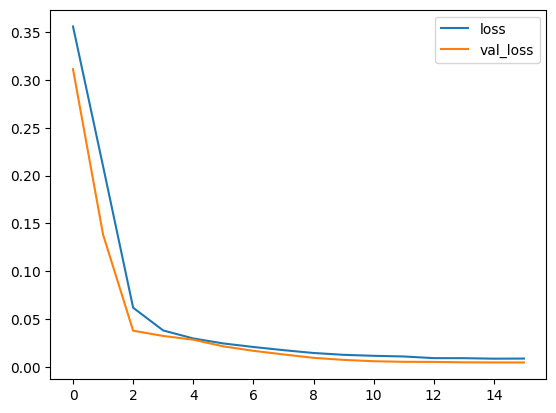

In [152]:
# Write your code here. Add as many boxes as you need.
sns.lineplot(history.history['loss'], label = 'loss')
sns.lineplot(history.history['val_loss'], label = 'val_loss')

Use the trained model to make predictions for the test set.

In [154]:
# Write your code here. Add as many boxes as you need.
y_pred = model.predict(x_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [156]:
y_pred = scaler.inverse_transform(y_pred)

Assess the performance of the model by using different metrics provided by the `scikit-learn` library.

In [158]:
# Write your code here. Add as many boxes as you need.
print(r2_score(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))

0.912386617125521
1.3135053104128558
2.8529499668719565


Create a line plot in order to compare the actual and predicted mean temperatures for the test set.

In [57]:
# Write your code here. Add as many boxes as you need.

# Laboratory Exercise - Bonus Task (+ 2 points)

As a bonus task for this laboratory exercise, calculate the Simple Moving Average (SMA) and Weighted Moving Average (WMA) with 3 timesteps for `mean_temperature` over the past 1, 2, and 3 days:

- **SMA with 3 timesteps ($\text{SMA}_3$)** - the average of temperatures from the previous 3 days:  
  $SMA_3 = \frac{\text{mean\_temperaure}_{lag\_3} +\ \text{mean\_temperaure}_{lag\_2} +\ \text{mean\_temperaure}_{lag\_1}}{1\ +\ 1\ +\ 1}$.

- **WMA with 3 timesteps ($\text{WMA}_3$)** - a weighted average, giving more importance to recent days:  
  $WMA_3 = \frac{1\ \cdot\ \text{mean\_temperaure}_{lag\_3} +\ 2\ \cdot\ \text{mean\_temperaure}_{lag\_2} +\ 3\ \cdot\ \text{mean\_temperaure}_{lag_1}}{1\ +\ 2\ +\ 3}$.

Then use this indicators alongside the other features in the dataset to predict the `mean_temperaure`.

*Hint: Use the `rolling` method from `pandas`. Check the docs at the following link https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html.*

In [60]:
# Write your code here. Add as many boxes as you need.